In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import matplotlib.pyplot as plt
import seaborn as sns

<h2> Load User Interaction Matrix </h2>

In [2]:
train_x = pd.read_csv("./data/MovieLens/ua.base", sep='\t', encoding='latin-1', header=None)
test_x = pd.read_csv("./data/MovieLens/ua.test", sep='\t', encoding='latin-1', header=None)
for df in [train_x, test_x]:
    df.columns = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

In [3]:
num_users, num_movie = train_x.user_id.max(), train_x.movie_id.max()
intmatrix = np.zeros((num_users, num_movie), dtype=np.float64)
for row in train_x.itertuples():
    intmatrix[row[1]-1, row[2]-1] = row[3]
print(intmatrix.shape)

(943, 1682)


In [4]:
np.savez("./data/movie-matrix", data=intmatrix)

<h2> Vanilla User-User and Item-Item Similarity </h2>

In [4]:
def optimized_row_cosine_sim(matrix): #nxm matrix
    dot = np.matmul(matrix, matrix.T) #nxn dot products
    lth = np.sqrt((matrix**2).sum(axis=1)) #nx1 length vector
    rowlth = np.repeat(lth.reshape(-1,1), matrix.shape[0], axis=1)
    collth = np.repeat(lth.reshape(1,-1), matrix.shape[0], axis=0)
    return dot/(rowlth*collth+1e-8) #1e-8 avoids div0 errors for unknown entries

In [5]:
user_similarity_old = optimized_row_cosine_sim(intmatrix)
item_similarity_old = optimized_row_cosine_sim(intmatrix.T)
user_similarity_old.shape, item_similarity_old.shape

((943, 943), (1682, 1682))

In [6]:
def vanilla_mean(mxm):
    mean_rating = np.nanmean(mxm, axis=1)
    return (mxm-mean_rating.reshape(-1,1)), mean_rating

In [7]:
def user_recommender_help(ratematrix, simmatrix, meanfunc):
    diff, mean_rating = meanfunc(ratematrix)
    preddiff = np.matmul(simmatrix, diff)/(np.repeat(np.sum(np.abs(
        simmatrix), axis=1).reshape(-1,1), ratematrix.shape[1], axis=1)+1e-8) #Div0 error avoidance
    return np.repeat(mean_rating.reshape(-1,1), ratematrix.shape[1], axis=1)+preddiff
def top_k_unseen_user_recommender(ratematrix, simmatrix, user, k, meanfunc):
    predrating = user_recommender_help(ratematrix, simmatrix, meanfunc)[user]
    predrating = pd.Series(predrating, index=np.arange(predrating.shape[0])+1)[np.where(
        ratematrix[user]==0)[0]+1].sort_values(ascending=False)
    return predrating.iloc[:k]

In [8]:
#Top items to be recommended to chosen user
top_k_unseen_user_recommender(intmatrix, user_similarity_old, 0, 5, vanilla_mean)

318    2.171805
423    2.072825
357    1.987419
117    1.965397
202    1.919865
dtype: float64

In [9]:
def item_recommender_help(ratematrix, simmatrix, meanfunc):
    diff, _ = meanfunc(ratematrix)
    diff = diff.T
    predfit = np.matmul(simmatrix, diff)/(np.repeat(np.sum(np.abs(
    simmatrix), axis=1).reshape(-1,1), diff.shape[1], axis=1)+1e-8) #Div0 error avoidance
    return predfit
def top_k_users_for_item_recommender(ratematrix, simmatrix, item, k, meanfunc):
    predfit = item_recommender_help(ratematrix, simmatrix, meanfunc)[item]
    predfit = pd.Series(predfit, index=np.arange(predfit.shape[0])+1)[np.where(
        ratematrix[:,item]==0)[0]+1].sort_values(ascending=False)
    return predfit.iloc[:k]

In [10]:
#Top users who might really like chosen item
top_k_users_for_item_recommender(intmatrix, item_similarity_old, 0, 5, vanilla_mean)

7      0.748582
308    0.740049
551    0.728063
474    0.703333
846    0.691157
dtype: float64

<h2> Improving Vanilla Similarity with Targetted Comparisons </h2>

Changes include (i) Calculating averages only over non-zero entries, (ii) calculating similarity on deviations from mean rating, and (iii) adding a sigmoid similarity layer to check number of similarities

In [11]:
def adjusted_mean(matrix):
    mean = np.sum(matrix, axis=1)/(matrix!=0).sum(axis=1)
    zmask = matrix==0
    matrix = matrix-mean.reshape(-1,1)
    matrix[zmask]=0
    return matrix, mean

In [12]:
def optimized_row_cosine_sim(matrix): #nxm matrix
    #Preparing difference-from-mean matrix
    matrix, _ = adjusted_mean(matrix)
    dot = np.matmul(matrix, matrix.T) #nxn dot products
    lth = np.sqrt((matrix**2).sum(axis=1)) #nx1 length vector
    rowlth = np.repeat(lth.reshape(-1,1), matrix.shape[0], axis=1)
    collth = np.repeat(lth.reshape(1,-1), matrix.shape[0], axis=0)
    fnl = dot/(rowlth*collth+1e-8) #1e-8 avoids div0 errors for unknown entries
    #Sigmoid-adjustment for number of common entries
    sg = np.diag((matrix!=0).sum(axis=1)-1) + np.ones((matrix.shape[0],matrix.shape[0]))
    sg = np.matmul(sg, sg) - sg.shape[0] + 2
    sg = 1/(1+np.exp(-np.log(np.sqrt(sg)))) #Can be simplified for log-exp but maintained for sigmoid clarity
    return fnl*sg

In [13]:
user_similarity_new = optimized_row_cosine_sim(intmatrix)
item_similarity_new = optimized_row_cosine_sim(intmatrix.T)
user_similarity_new.shape, item_similarity_new.shape

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


((943, 943), (1682, 1682))

In [14]:
#Top items to be recommended to chosen user
top_k_unseen_user_recommender(intmatrix, user_similarity_new, 0, 5, adjusted_mean)

318    3.925751
483    3.866581
357    3.856024
313    3.830422
603    3.800225
dtype: float64

In [15]:
x = user_recommender_help(intmatrix, user_similarity_new, adjusted_mean)[0]

In [16]:
#Top users who might really like chosen item
top_k_users_for_item_recommender(intmatrix, item_similarity_new, 0, 5, adjusted_mean)

405    0.256212
95     0.062816
506    0.055644
109    0.054716
749    0.044214
dtype: float64

<h2> Visualizing Recommendation Differences </h2>

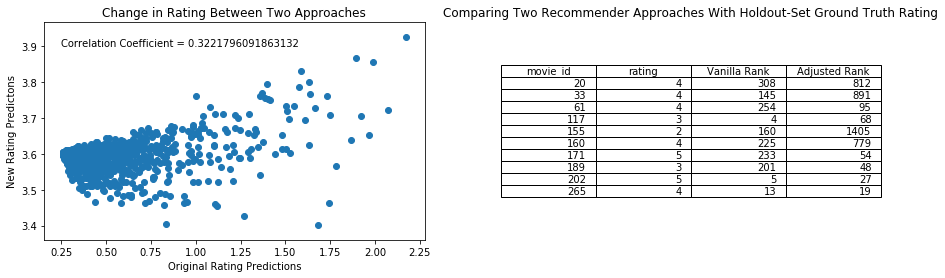

In [53]:
#Comparing Vanilla and Modified Approach (User-Similarity)
user= 1
vn = top_k_unseen_user_recommender(intmatrix, user_similarity_old, user-1, intmatrix.shape[1], vanilla_mean)
an = top_k_unseen_user_recommender(intmatrix, user_similarity_new, user-1, intmatrix.shape[1], adjusted_mean)
#Prepare Scatterplot
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.scatter(vn.values, an[vn.index].values)
plt.text(0.25, 3.9, "Correlation Coefficient = "+
         str(np.corrcoef(vn.values, an[vn.index].values)[0][1]))
plt.xlabel("Original Rating Predictions")
plt.ylabel("New Rating Predictons")
plt.title("Change in Rating Between Two Approaches")
#Comparisons to Known Recommendations
ax = plt.subplot(1,2,2)
plt.title("Comparing Two Recommender Approaches With Holdout-Set Ground Truth Rating")
ax.axis('tight')
ax.axis('off')
vnrank = pd.Series(np.arange(len(vn))+1, index=vn.sort_values(ascending=False).index)
anrank = pd.Series(np.arange(len(an))+1, index=an.sort_values(ascending=False).index)
comp = test_x.loc[test_x.user_id==user][["movie_id", "rating"]]
comp["Vanilla Rank"] = vnrank[comp.movie_id.values].values
comp["Adjusted Rank"] = anrank[comp.movie_id.values].values
tbl = ax.table(cellText=comp.values, colLabels=comp.columns, loc="center")
plt.show()

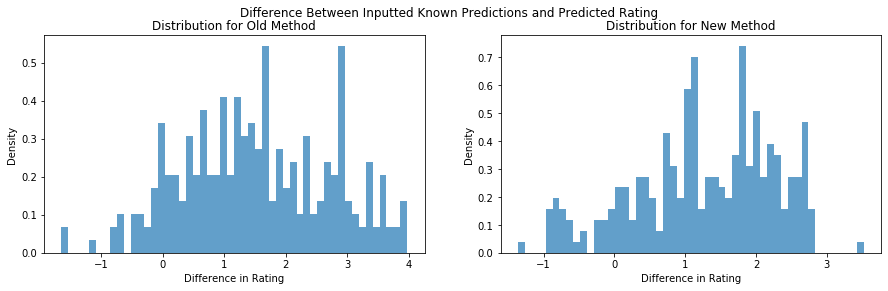

In [57]:
#Ability to Capture Current Ratings (User-Similarity)
user = 1
tbl = train_x.loc[train_x.user_id==user]
#Plotting Univariate Distributions
plt.figure(figsize=(15,4))
plt.suptitle("Difference Between Inputted Known Predictions and Predicted Rating")
for plot, sim, mean, title in [(1,user_similarity_old,vanilla_mean,"Old"),
                               (2,user_similarity_new,adjusted_mean,"New")]:  
    plt.subplot(1,2,plot)
    plt.title("Distribution for "+title+" Method")
    x = user_recommender_help(intmatrix, sim, mean)[user-1]
    x = x[tbl.movie_id.values-1]
    x = (x - x.min())/(x.max()-x.min())*4+1
    plt.hist(tbl.rating.values-x, bins=50, alpha=0.7, density=True)
    plt.xlabel("Difference in Rating")
    plt.ylabel("Density")
plt.show()

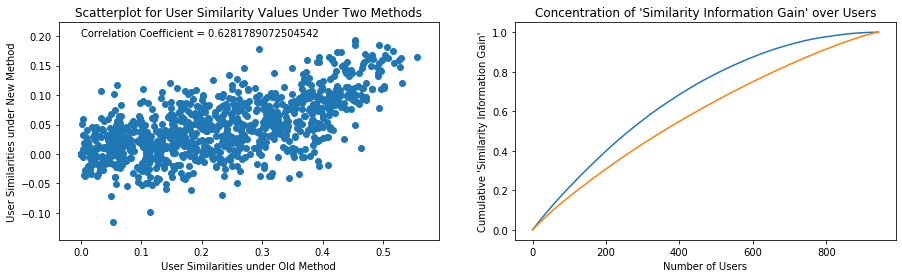

In [59]:
#Exposing Similarity Concentration
user = 1
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
mask = np.repeat(True, intmatrix.shape[0])
mask[user-1] = False
plt.scatter(user_similarity_old[user-1][mask], user_similarity_new[user-1][mask])
plt.text(0, 0.2, "Correlation Coefficient = "+
         str(np.corrcoef(user_similarity_old[user-1][mask], user_similarity_new[user-1][mask])[0][1]))
plt.xlabel("User Similarities under Old Method")
plt.ylabel("User Similarities under New Method")
plt.title("Scatterplot for User Similarity Values Under Two Methods")
plt.subplot(1,2,2)
def scaler(series):
    return (series-series.min())/(series.max()-series.min())
old, new = scaler(user_similarity_old[user-1]), scaler(user_similarity_new[user-1])
plt.plot(scaler(np.sort(old)[::-1].cumsum()))
plt.plot(scaler(np.sort(new)[::-1].cumsum()))
plt.xlabel("Number of Users")
plt.ylabel("Cumulative 'Similarity Information Gain'")
plt.title("Concentration of 'Similarity Information Gain' over Users")
plt.show()